In [0]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, count, mean, desc
import io
import base64
from IPython.display import display, HTML
from pyspark.sql import functions as F
from pyspark.sql.functions import when
from pyspark.sql.functions import col

import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import when

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
# Team folder
section = "4"
number = "4"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"
data_path_12M = f"{folder_path}/data_12M/"


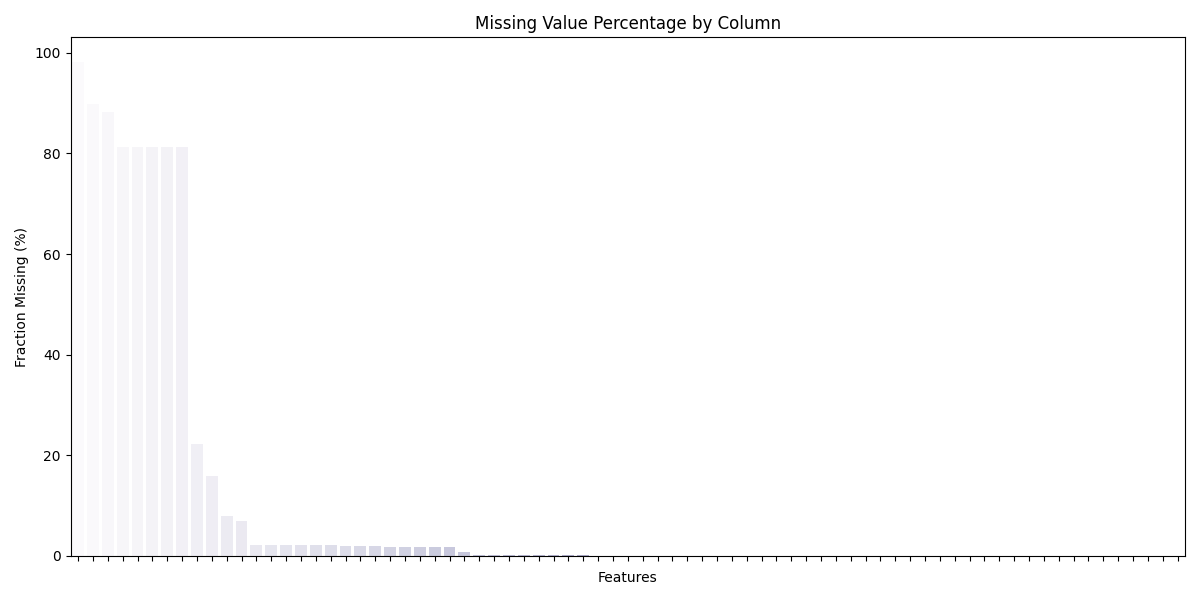

In [0]:



# Load OTPW database
#df = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
df = spark.read.format("parquet").option("header","true").load(f"{folder_path}/JOINED_1Y_2019.parquet")

total = df.count()

# Count non-null values for every column
non_null_agg = df.agg(*[F.count(c).alias(c) for c in df.columns])

# Reshape into (column, non_null)
nulls_long = non_null_agg.selectExpr(
    "stack({}, {}) as (column, non_null)".format(
        len(df.columns),
        ", ".join([f"'{c}', `{c}`" for c in df.columns])
    )
).withColumn("null_count", F.lit(total) - F.col("non_null")) \
 .withColumn("null_pct", F.round(F.col("null_count") / F.lit(total) * 100, 2)) \
 .orderBy(F.desc("null_pct"))

nulls_pd = nulls_long.select("column", "null_pct").toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    x="column",
    y="null_pct",
    data=nulls_pd,
    palette="Purples",
    hue="column",
    legend=False
)
plt.title("Missing Value Percentage by Column")
plt.ylabel("Fraction Missing (%)")
plt.xlabel("Features")
plt.gca().set_xticklabels([])
plt.subplots_adjust(bottom=0.25, left=0.08, right=0.98, top=0.92)
plt.tight_layout()

buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()

display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This plot summarizes completeness across all features in the OTPW sample by showing, for each column, the percentage of missing values. Even though the x-axis labels are suppressed (because we have 200+ columns), the shape of the bars makes two things clear: (i) there is a long tail of variables with very high missingness (often >80–90%), and (ii) only a smaller core of features is reasonably complete. This confirms what we saw in the raw schema: many weather subfields, delay-breakdown columns, and station-level attributes are too sparse to feed directly into a T–2h classifier. The practical implication is that we must either drop the extreme-sparsity columns up front or group them under targeted imputation rules, otherwise they will bloat the feature space and slow training without adding signal.

In [0]:
# Select columns for EDA
eda_cols = [
    "DEP_DEL15", "OP_UNIQUE_CARRIER","CRS_DEP_TIME","ORIGIN", "DISTANCE",
    "MONTH", "DAY_OF_WEEK", "DEP_DELAY", "TAXI_OUT",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed", 'HourlyDryBulbTemperature'
]

In [0]:
df_otpw = df
df_otpw = df_otpw.select(*[c for c in eda_cols if c in df_otpw.columns])
df_otpw = df_otpw.dropna(subset=["DEP_DEL15", "ORIGIN"])

# Step 3: Cast numerical columns to the correct types
df_otpw = (
    df_otpw
    .withColumn("DEP_DEL15", F.col("DEP_DEL15").cast("double"))
    .withColumn("DISTANCE", F.col("DISTANCE").cast("double"))
    .withColumn("DAY_OF_WEEK", F.col("DAY_OF_WEEK").cast("int"))
    .withColumn("MONTH", F.col("MONTH").cast("int"))
    .withColumn("DEP_DELAY", F.col("DEP_DELAY").cast("double"))
    .withColumn("TAXI_OUT", F.col("TAXI_OUT").cast("double"))
    .withColumn("HourlyPrecipitation", F.col("HourlyPrecipitation").cast("double"))
    .withColumn("HourlyVisibility", F.col("HourlyVisibility").cast("double"))
    .withColumn("HourlyWindSpeed", F.col("HourlyWindSpeed").cast("double"))
    .withColumn("HourlyDryBulbTemperature", F.col("HourlyDryBulbTemperature").cast("double"))
)

# Optional: Verify schema and non-null record count
#df_otpw.printSchema()
#print(f"Total cleaned records: {df_otpw.count():,}")


In [0]:
from functools import reduce

after_cnt = df_otpw.count()
summaries = []

for c, t in df_otpw.dtypes:
    # Make sure the column actually exists
    if c not in df_otpw.columns:
        continue

    # Base summary: column name, dtype, null rate
    base = df_otpw.select(
        F.lit(c).alias("column"),
        F.lit(t).alias("dtype"),
        (F.sum(F.col(c).isNull().cast("int")) / F.lit(after_cnt)).alias("null_rate")
    )

    # If numeric column, include min / median / max
    if t in ("int", "bigint", "double", "float"):
        base = df_otpw.select(
            F.lit(c).alias("column"),
            F.lit(t).alias("dtype"),
            (F.sum(F.col(c).isNull().cast("int")) / F.lit(after_cnt)).alias("null_rate"),
            F.min(F.col(c)).alias("min"),
            F.expr(f"percentile_approx(`{c}`, 0.5)").alias("median"),
            F.max(F.col(c)).alias("max")
        )

    summaries.append(base)

# Combine all summaries
dq_summary = reduce(lambda a, b: a.unionByName(b, allowMissingColumns=True), summaries)
#display(dq_summary.orderBy(F.desc("null_rate")))


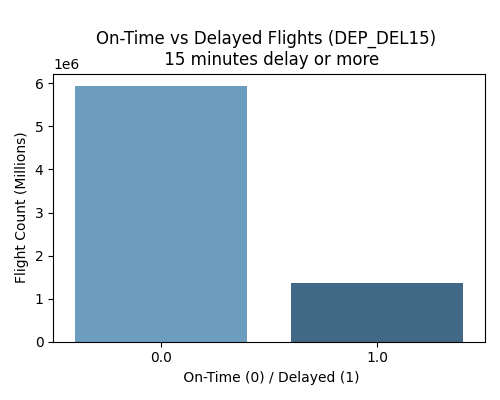

In [0]:
# 1. Target variable imbalance (DEP_DEL15)
dep_del15_counts = (
    df_otpw.groupBy("DEP_DEL15")
    .count()
    .orderBy("DEP_DEL15")
)
dep_del15_pd = dep_del15_counts.toPandas()

plt.figure(figsize=(5, 4))
sns.barplot(
    x="DEP_DEL15",
    y="count",
    data=dep_del15_pd,
    palette="Blues_d",
    hue="DEP_DEL15",
    legend=False
)
plt.title("On-Time vs Delayed Flights (DEP_DEL15) \n 15 minutes delay or more")
plt.xlabel(" On-Time (0) / Delayed (1)")
plt.ylabel("Flight Count (Millions)")
plt.tight_layout()

# Center display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()

display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This chart shows the core imbalance in our prediction task: roughly 4 out of every 5 flights are on time (DEP_DEL15 = 0) and only about 1 out of 5 are delayed 15+ minutes (DEP_DEL15 = 1). That 80/20 split means a naïve model could get ~80% accuracy by always predicting “on time,” so later we must use recall-friendly metrics (F₂, PR-AUC) and possibly class weighting to avoid that failure mode.


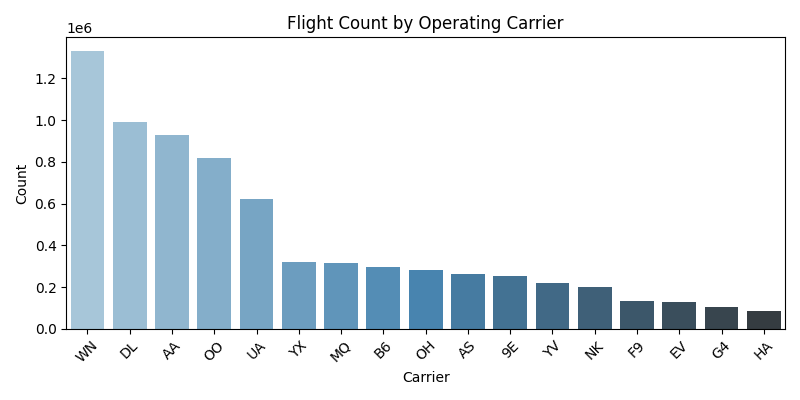

In [0]:
# 2. Unique operating carriers
carrier_counts = df_otpw.groupBy("OP_UNIQUE_CARRIER").count().orderBy(desc("count"))
carrier_pd = carrier_counts.toPandas()
plt.figure(figsize=(8,4))
sns.barplot(x="OP_UNIQUE_CARRIER", 
            y="count", 
            data=carrier_pd, 
            palette="Blues_d",
            hue="OP_UNIQUE_CARRIER",
            legend=False)
plt.title("Flight Count by Operating Carrier")
plt.xlabel("Carrier")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This plot confirms the dataset is dominated by a handful of large U.S. carriers (WN, AA, DL, UA, etc.), with several smaller airlines contributing far fewer rows. That matters for modeling because carrier will look like a strong feature, but the tail carriers have less support — so when we report metrics later, we should slice performance by carrier to make sure the model isn’t only good on the big four.

#### 3.4.2 Time-Based Delay Patterns


##### 3.4.2.1 Hourly Delay Rate


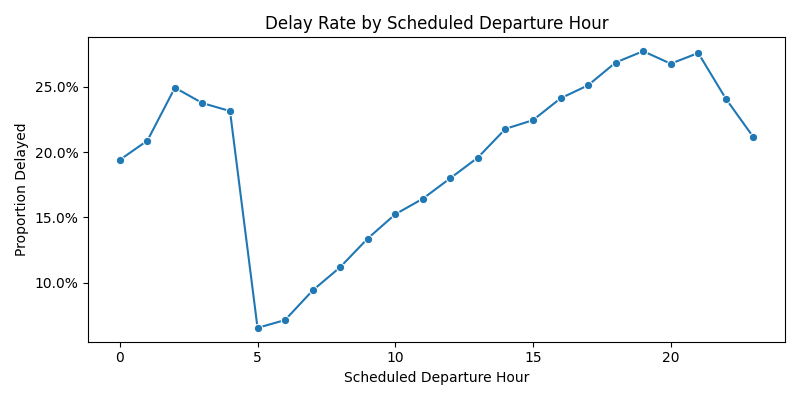

In [0]:
df_otpw = df_otpw.withColumn("CRS_DEP_HOUR", (F.col("CRS_DEP_TIME").cast("int") / 100).cast("int"))

delay_by_hour = (
    df_otpw.groupBy("CRS_DEP_HOUR")
    .agg(F.mean(F.col("DEP_DEL15").cast("double")).alias("delay_rate"))
    .orderBy("CRS_DEP_HOUR")
)
delay_by_hour = df_otpw.groupBy("CRS_DEP_HOUR").agg(mean("DEP_DEL15").alias("delay_rate")).orderBy("CRS_DEP_HOUR")
delay_by_hour_pd = delay_by_hour.toPandas()
plt.figure(figsize=(8,4))
sns.lineplot(x="CRS_DEP_HOUR", y="delay_rate", data=delay_by_hour_pd, marker="o")
plt.title("Delay Rate by Scheduled Departure Hour")
plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Proportion Delayed")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)


**Observation**

The hourly trend shows that flights departing **early in the morning (around 5–8 AM)** 
have the **lowest delay rates**, while those departing in the **late afternoon and evening (around 5–9 PM)** 
experience the **highest delays**.  
This pattern reflects the **cumulative operational congestion** that builds up throughout the day.


##### 3.4.2.2 Day-of-Week Delay Rate


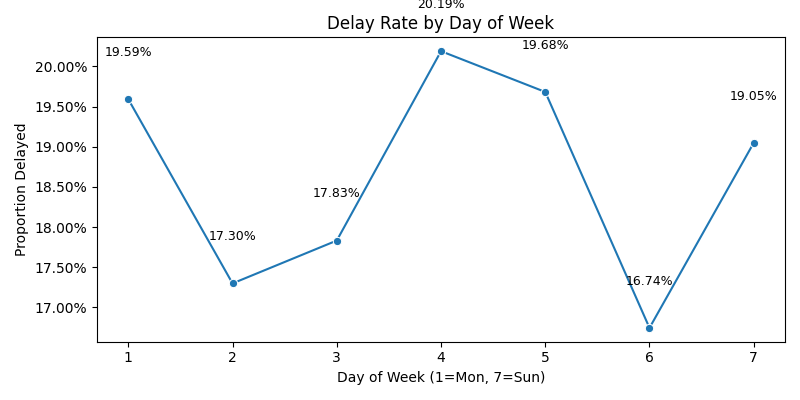

In [0]:
df_otpw = df_otpw.withColumn("DAY_OF_WEEK", (F.col("DAY_OF_WEEK")).cast("int"))

delay_by_day = (
    df_otpw.groupBy("DAY_OF_WEEK")
    .agg(F.mean(F.col("DEP_DEL15").cast("double")).alias("delay_rate"))
    .orderBy("DAY_OF_WEEK")
)
delay_by_day = df_otpw.groupBy("DAY_OF_WEEK").agg(mean("DEP_DEL15").alias("delay_rate")).orderBy("DAY_OF_WEEK")
delay_by_day_pd = delay_by_day.toPandas()
plt.figure(figsize=(8,4))
sns.lineplot(x="DAY_OF_WEEK", y="delay_rate", data=delay_by_day_pd, marker="o")
plt.title("Delay Rate by Day of Week")
plt.xlabel("Day of Week (1=Mon, 7=Sun)")
plt.ylabel("Proportion Delayed")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()

for x, y in zip(delay_by_day_pd["DAY_OF_WEEK"], delay_by_day_pd["delay_rate"]):
    plt.text(x, y + 0.005, f"{y*100:.2f}%", ha="center", va="bottom", fontsize=9)

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

**Observation**

Flights departing on **Mondays** and **weekends (especially Sundays)** 
show the **highest delay rates**, while **midweek flights (Tuesday–Wednesday)** 
tend to have the **lowest delays**.  
This pattern likely reflects heavier passenger traffic and tighter scheduling 
at the beginning and end of the week.

#### 3.4.3 Airport Delay Patterns


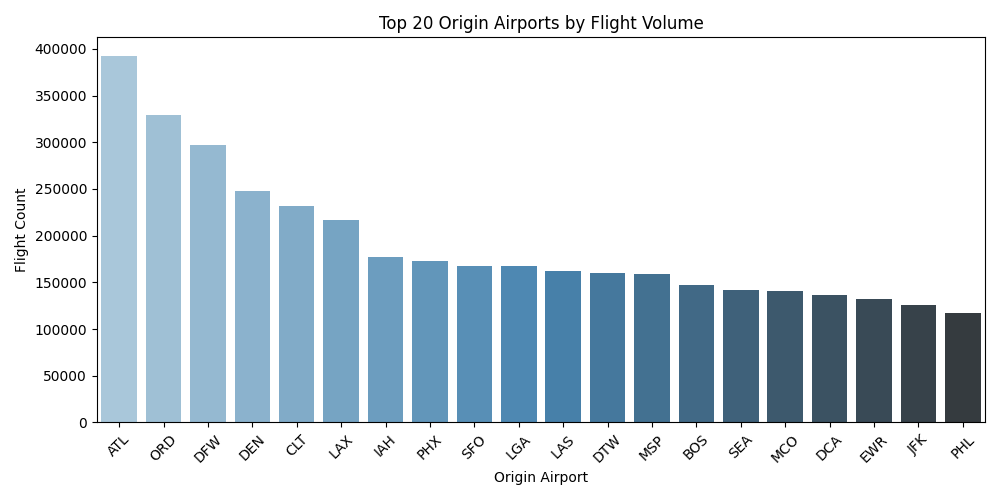

In [0]:
# 4. Flight volume by origin airport (top 20)
top_airports = df_otpw.groupBy("ORIGIN").count().orderBy(desc("count")).limit(20)
top_airports_pd = top_airports.toPandas()
plt.figure(figsize=(10,5))
sns.barplot(x="ORIGIN", 
            y="count", 
            data=top_airports_pd, 
            palette="Blues_d",
            hue="ORIGIN",
            legend=False
            )
plt.title("Top 20 Origin Airports by Flight Volume")
plt.xlabel("Origin Airport")
plt.ylabel("Flight Count")
plt.xticks(rotation=45)
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This chart shows that a small set of hub airports (ATL, ORD, DFW, DEN, LAX, etc.) concentrate most of the traffic in the 3-month sample. That reinforces two design choices in the project: (i) we must report model performance by airport, because mistakes at these hubs affect many more flights than mistakes at small fields; and (ii) airport-level features (congestion, weather joins, time-of-day effects) are worth the engineering effort since they will benefit the majority of records.


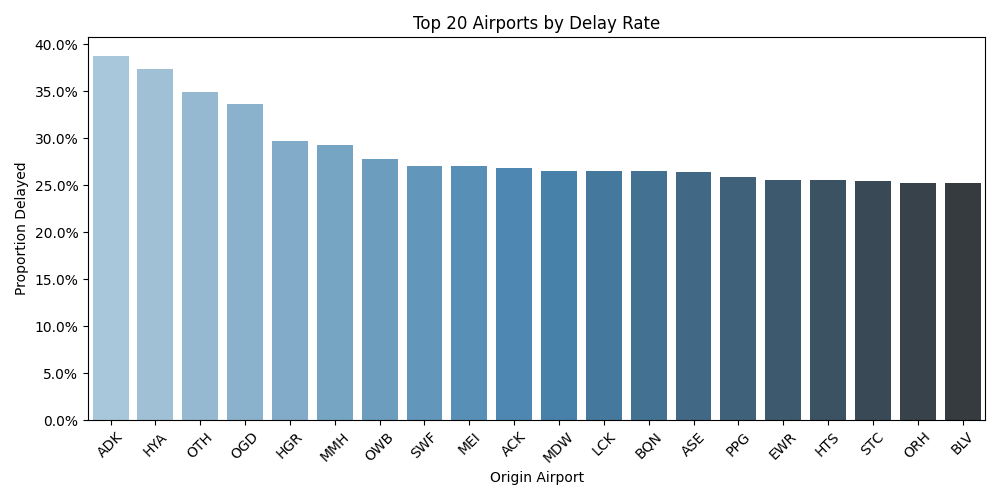

In [0]:
# 5. Delay rate by origin airport (top 10)
delay_by_airport = df_otpw.groupBy("ORIGIN").agg(mean("DEP_DEL15").alias("delay_rate")).orderBy(desc("delay_rate")).limit(20)
delay_by_airport_pd = delay_by_airport.toPandas()
plt.figure(figsize=(10,5))
sns.barplot(x="ORIGIN", y="delay_rate", 
            data=delay_by_airport_pd, 
            palette="Blues_d",
            hue="ORIGIN",
            legend=False
            )
plt.title("Top 20 Airports by Delay Rate")
plt.xlabel("Origin Airport")
plt.ylabel("Proportion Delayed")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=45)
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

Some origins with modest volume show very high delay proportions, while a few large hubs stay in the middle of the pack. That’s exactly why our metrics section asks for confusion by airport: if the model systematically under-flags a chronically delayed origin, ops at that station will think the model “doesn’t work,” even if the global F₂ looks good.

In [0]:
# Convert Spark DataFrame to Pandas and sort by delay rate descending
topN_sorted_by_busiest_pd = (
    topN_sorted_by_busiest
    .orderBy(F.desc("delay_rate_pct"))
    .toPandas()
)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for flight volume
bars = ax1.bar(topN_sorted_by_busiest_pd["ORIGIN"],
               topN_sorted_by_busiest_pd["num_flights"],
               color="orange", alpha=0.8, label="Flight Volume")

# Add labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 1000,
             f"{int(height):,}", ha="center", va="bottom", fontsize=9)

# Axis and labels
ax1.set_xlabel("Origin Airport")
ax1.set_ylabel("Flight Volume", color="darkorange", fontsize=12)
ax1.tick_params(axis="y", labelcolor="darkorange")

# Create second axis for delay rate
ax2 = ax1.twinx()
ax2.plot(topN_sorted_by_busiest_pd["ORIGIN"],
         topN_sorted_by_busiest_pd["delay_rate_pct"],
         color="teal", marker="o", linewidth=2, label="Delay Rate (%)")

# Add data labels for delay rate
for x, y in zip(topN_sorted_by_busiest_pd["ORIGIN"], topN_sorted_by_busiest_pd["delay_rate_pct"]):
    ax2.text(x, y + 0.3, f"{y:.2f}%", ha="center", va="bottom", color="teal", fontsize=9)

ax2.set_ylabel("Delay Rate (%)", color="teal", fontsize=12)
ax2.tick_params(axis="y", labelcolor="teal")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

# Title and layout
plt.title("Top 20 Busiest Airports Sorted by Delay Rate (%)", fontsize=14, weight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-7250714370593436>, line 3
      1 # Convert Spark DataFrame to Pandas and sort by delay rate descending
      2 topN_sorted_by_busiest_pd = (
----> 3     topN_sorted_by_busiest
      4     .orderBy(F.desc("delay_rate_pct"))
      5     .toPandas()
      6 )
      8 # Create figure and first axis
      9 fig, ax1 = plt.subplots(figsize=(12, 6))

NameError: name 'topN_sorted_by_busiest' is not defined

**Observation**

Among the busiest airports, **ORD** (Chicago O’Hare), **ATL** (Atlanta), and **DFW** (Dallas/Fort Worth) 
handle the highest flight volumes but also experience significant delays.  
High delay rates are often observed at major hubs due to **air traffic congestion, 
weather sensitivity, and connecting flight dependencies**.  
Conversely, airports like **PHX** and **SEA** maintain relatively low delay percentages 
despite heavy traffic, suggesting more efficient scheduling and operational management.


#### 3.4.4 Airline Delay Patterns

In [0]:
# --- Airline-level delay statistics with colors matched to airport chart ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Sort by delay rate (or change to num_flights if desired)
pdf = delay_by_carrier.orderBy(F.desc("delay_rate_pct")).toPandas()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars: flight volume (orange to match previous chart)
bar_color = "orange"     # same bar color
bars = ax1.bar(
    pdf["OP_UNIQUE_CARRIER"], pdf["num_flights"],
    color=bar_color, alpha=0.85, label="Flight Volume", edgecolor="none"
)

# Bar labels
for b in bars:
    h = b.get_height()
    ax1.text(b.get_x() + b.get_width()/2, h + 3000, f"{int(h):,}",
             ha="center", va="bottom", fontsize=9)

ax1.set_xlabel("Airline (OP_UNIQUE_CARRIER)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="x", rotation=45)
ax1.tick_params(axis="y", labelcolor=bar_color)

# Line: delay rate (teal to match previous chart)
line_color = "teal"      # same line color
ax2 = ax1.twinx()
ax2.plot(
    pdf["OP_UNIQUE_CARRIER"], pdf["delay_rate_pct"],
    color=line_color, marker="o", linewidth=2, label="Delay Rate (%)"
)

# Line labels
for x, y in zip(pdf["OP_UNIQUE_CARRIER"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.4, f"{y:.2f}%", ha="center", va="bottom",
             fontsize=9, color=line_color)

ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

plt.title("Delay Rate vs Flight Volume by Airline (sorted by delay rate)")
fig.tight_layout()
plt.show()


**Observation**

This chart shows meaningful differences in delay behavior across carriers. Frontier (F9), Envoy (MQ), and Breeze (B6) exhibit some of the highest delay rates despite relatively small flight volumes, indicating tighter schedules, limited buffers, or operational constraints. In contrast, major carriers such as Southwest (WN), American (AA), Delta (DL), and United (UA) operate far more flights while maintaining mid-range delay percentages. These patterns suggest that delays are influenced by both airline-specific operational discipline and the complexity of their route networks. Understanding these differences is important for modeling because carrier identity captures real operational variability that affects on-time performance.

#### 3.4.5 Weather Impact on Delays

##### 3.4.5.1 Temperature vs Delay Patterns 

In [0]:
# --- Delay Rate vs Flight Volume by Temperature (bins) ---

# 1) Collect Spark results and sort by temperature bin ascending
pdf = (
    temp_delay               # Spark DF: [Temp_bin, delay_rate_pct, num_flights]
    .orderBy("Temp_bin")
    .toPandas()
)

# 2) Create figure + left axis (flight volume as bars)
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_color  = "orange"   # keep same as previous charts
line_color = "teal"     # keep same as previous charts

bars = ax1.bar(
    pdf["Temp_bin"], pdf["num_flights"],
    color=bar_color, alpha=0.85, label="Flight Volume", width=4.5
)

# Add labels on bars (thin the labels if many bins)
for b in bars:
    h = b.get_height()
    if h > 0:
        ax1.text(b.get_x() + b.get_width()/2, h + 1500, f"{int(h):,}",
                 ha="center", va="bottom", fontsize=8, rotation=90)

ax1.set_xlabel("Temperature Bins (°F)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="y", labelcolor=bar_color)

# 3) Right axis (delay rate line)
ax2 = ax1.twinx()
ax2.plot(
    pdf["Temp_bin"], pdf["delay_rate_pct"],
    color=line_color, marker="o", linewidth=2, label="Delay Rate (%)"
)

# Add data labels for the line
for x, y in zip(pdf["Temp_bin"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.3, f"{y:.1f}%", ha="center", va="bottom",
             fontsize=8, color=line_color)

ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

# Styling
plt.title("Delay Rate vs Flight Volume by Temperature (sorted by Temp_bin)")
plt.tight_layout()
plt.show()


**Observation**

The chart Delay Rate vs Flight Volume by Temperature reveals a **U-shaped relationship** between temperature and flight delays.  
Flights departing in **moderate temperatures (40–70°F)** experience the **lowest delay rates** (around 12–17%),  
while **extreme cold (below 20°F)**  correspond to **higher delays**, reaching up to **35%**.

##### 3.4.5.2 Wind Speed vs Delay Patterns 

In [0]:
# --- Delay Rate vs Flight Volume by Wind Speed (bins) ---

# 1) Collect Spark results (ensure ascending bins)
pdf = wind_delay.orderBy("Wind_bin").toPandas()   # columns: Wind_bin, delay_rate_pct, num_flights

# 2) Create dual-axis figure
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_color  = "orange"    # match previous charts
line_color = "teal"

# Bars = flight volume
bars = ax1.bar(pdf["Wind_bin"], pdf["num_flights"], color=bar_color, alpha=0.85, width=1.8, label="Flight Volume")
ax1.set_xlabel("Wind Bins (mph)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="y", labelcolor=bar_color)

# Optional: thin bar labels if many bins
for b in bars:
    h = b.get_height()
    if h > 0:
        ax1.text(b.get_x() + b.get_width()/2, h + 4000, f"{int(h):,}",
                 ha="center", va="bottom", fontsize=8, rotation=90)

# Line = delay rate (%)
ax2 = ax1.twinx()
ax2.plot(pdf["Wind_bin"], pdf["delay_rate_pct"], color=line_color, marker="o", linewidth=2, label="Delay Rate (%)")
for x, y in zip(pdf["Wind_bin"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.4, f"{y:.1f}%", ha="center", va="bottom", fontsize=8, color=line_color)

ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

plt.title("Delay Rate vs Flight Volume by Wind Speed (sorted by Wind_bin)")
plt.tight_layout()
plt.show()


**Observation**

Most flights occur under moderate wind speeds (around 5–15 mph), where delay rates remain relatively low.  
As wind speed increases beyond 20 mph, delay rates rise sharply while flight volume drops, suggesting that strong winds significantly disrupt flight operations.

##### 3.4.5.3 Precipitation vs Delay Patterns

To ensure statistical reliability, bins with fewer than 100 flights were excluded, as their delay rates fluctuate excessively due to small sample sizes.
Additionally, the no-precipitation group (0.00 inches) was removed since it represents over 90% of all flights and dominates the visualization.

In [0]:
# --- Delay Rate vs Flight Volume by Precipitation (bins) ---
# Convert Spark DataFrame to Pandas
pdf = precip_filtered.orderBy("Precip_bin").toPandas()

bar_color = "orange"
line_color = "teal"

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Bar chart for flight volume ---
bars = ax1.bar(pdf["Precip_bin"], pdf["num_flights"], color=bar_color, alpha=0.85, width=0.008)
ax1.set_xlabel("Precipitation Bins (in/hr)")
ax1.set_ylabel("Flight Volume", color=bar_color)
ax1.tick_params(axis="y", labelcolor=bar_color)

# Add data labels on bars
for b in bars:
    h = b.get_height()
    if h > 0:
        ax1.text(b.get_x() + b.get_width()/2, h + 200, f"{int(h):,}", 
                 ha="center", va="bottom", fontsize=8, rotation=90)

# --- Line chart for delay rate ---
ax2 = ax1.twinx()
ax2.plot(pdf["Precip_bin"], pdf["delay_rate_pct"], color=line_color, marker="o", linewidth=2)
ax2.set_ylabel("Delay Rate (%)", color=line_color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax2.tick_params(axis="y", labelcolor=line_color)

# Force the right axis to start from 0
upper = float(pdf["delay_rate_pct"].max())
ax2.set_ylim(0, max(10, upper) + 2)

# Add data labels for delay rate
for x, y in zip(pdf["Precip_bin"], pdf["delay_rate_pct"]):
    ax2.text(x, y + 0.3, f"{y:.1f}%", ha="center", va="bottom", fontsize=8, color=line_color)

# --- Title and layout ---
plt.title("Delay Rate vs Flight Volume by Precipitation (sorted by Precip_bin)")
plt.tight_layout()
plt.show()

**Observation**

After excluding bins with precipitation = 0 and fewer than 100 flights,
the distribution reveals a meaningful relationship between rainfall intensity and flight delays.  

- **Light rain (<0.05 inches)** already shows a mild increase in delay rate (~29%).  
- **Moderate rain (0.10–0.15 inches)** corresponds to a noticeable rise, around **35–40% delay rate**.  
- For **heavier precipitation (>0.20 inches)**, the sample size drops sharply, but the delay rate remains consistently high (30–37%).  

Overall, **delay probability tends to rise with increasing precipitation**, especially once rainfall exceeds **0.10 inches**, indicating that wet weather significantly disrupts flight operations.


#### 3.4.6 Visibility Impact on Delays

In [0]:
# 7. Delay rate by visibility bins
bins = [0,2,5,10,20]
labels = ["Very Low","Low","Medium","High"]
bin_expr = when(col("HourlyVisibility") <= 2, "Very Low") \
    .when((col("HourlyVisibility") > 2) & (col("HourlyVisibility") <= 5), "Low") \
    .when((col("HourlyVisibility") > 5) & (col("HourlyVisibility") <= 10), "Medium") \
    .otherwise("High")
df_vis_bin = df_otpw.withColumn("Visibility_bin", bin_expr)
vis_delay = df_vis_bin.groupBy("Visibility_bin").agg(mean("DEP_DEL15").alias("delay_rate"))
vis_delay_pd = vis_delay.toPandas()
plt.figure(figsize=(6,4))
sns.barplot(x="Visibility_bin", 
            y="delay_rate", 
            data=vis_delay_pd, 
            palette="Purples",
            hue="Visibility_bin",
            legend=False
            )
plt.title("Delay Rate by Visibility Bin")
plt.xlabel("Visibility Bin")
plt.ylabel("Proportion Delayed")
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

This plot shows the expected weather signal: flights that depart under very low visibility (≤2 miles) have the highest proportion of 15+ minute delays, and the delay rate steadily improves as visibility increases.

#### 3.4.7 Correlation heatmap

In [0]:
# Correlation heatmap for key numeric features
#df_corr_sample = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
df_corr_sample = df

corr_cols = [
    "DEP_DELAY", "TAXI_OUT", "AIR_TIME", "DISTANCE",
    "ARR_DELAY", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME",
    "HourlyPrecipitation", "HourlyVisibility", "HourlyWindSpeed",
    "DEP_DEL15"
]
sample_df = df_corr_sample.select([col(c).cast("double") for c in corr_cols]).dropna().limit(10000)
sample_pd = sample_df.toPandas()
corr_matrix = sample_pd.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Key Features")
plt.tight_layout()

# Centering display
buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()
display(
    HTML(
        f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
    )
)

In [0]:
# List your entire user directory
response = requests.get(
    f'https://{host_name}/api/2.0/workspace/list',
    headers={'Authorization': f'Bearer {token}'},
    params={'path': '/Users/aagarwal19@berkeley.edu'}
)

print("Your user directory contents:")
for obj in response.json().get('objects', []):
    print(f"{obj['object_type']}: {obj['path']}")
import requests
import json

# Get context info
ctx = dbutils.notebook.entry_point.getDbutils().notebook().getContext()
host_name = ctx.tags().get("browserHostName").get()
token = ctx.apiToken().get()

# Use the workspace/get-status API with the folder ID
folder_id = "1739154845297671"

response = requests.get(
    f'https://{host_name}/api/2.0/workspace/get-status',
    headers={'Authorization': f'Bearer {token}'},
    params={'path': f'/Users/aagarwal19@berkeley.edu/Charts'}
)

print("Folder info:")
print(json.dumps(response.json(), indent=2))

# Now list the contents
response = requests.get(
    f'https://{host_name}/api/2.0/workspace/list',
    headers={'Authorization': f'Bearer {token}'},
    params={'path': '/Users/aagarwal19@berkeley.edu/Charts'}
)

print("\nFolder contents:")
contents = response.json()
print(json.dumps(contents, indent=2))

# Print just the file names for easy copying
if 'objects' in contents:
    print("\n=== File List ===")
    for obj in contents['objects']:
        print(f"{obj['path']}")
import shutil
import os

# Source directory (Workspace)
source_dir = "/Workspace/Users/aagarwal19@berkeley.edu/Charts"

# Destination directory (DBFS)
dest_dir = "/dbfs/student-groups/Group_4_4/Charts"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# List of files to copy
files = [
    "delay_rate_vs_flight_volume_precipitation.png",
    "delay_rate_vs_flight_volume_wind_speed.png",
    "delay_rate_vs_flight_volume_temperature.png",
    "flight_count_by_operating_carrier.png",
    "On-Time vs Delayed Flights (DEP_DEL15) 15 minutes delay or more.png",
    "top_20_airport_origin_by_flight_volume.png",
    "top_20_airports_by_delay_rate.png",
    "delay_rate_by_schedlued_departure_date.png",
    "delay_rate_by_day_of_week.png",
    "delay_rate_by_visibility_bin.png",
    "delay_rate_by_flight_volume_by_airline.png",
    "missing_value_percentage_by_column.png",
    "top_20_busiest_airports_sorted_by_delay_rate.png",
    "correlation_matrix.png"
]

# Copy each file
for filename in files:
    source_path = os.path.join(source_dir, filename)
    dest_path = os.path.join(dest_dir, filename)
    
    try:
        shutil.copy2(source_path, dest_path)
        print(f"✓ Copied: {filename}")
    except Exception as e:
        print(f"✗ Error copying {filename}: {str(e)}")

print(f"\n=== Copy Complete ===")
print(f"Files copied to: dbfs:/student-groups/Group_4_4/Charts/")

# Verify the files are there
print("\nVerifying files in destination:")
dbutils.fs.ls("dbfs:/student-groups/Group_4_4/Charts/")